In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from PIL import Image
from tqdm import tqdm
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
from sklearn.model_selection import train_test_split
import random

# Define the dataset
class ImageDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
# Define the dataset
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.JPG')]
        self.mask_files = [f.replace('.JPG', '.png') for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.image_files[index])
        mask_path = os.path.join(self.data_dir, self.mask_files[index])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((500, 500)),  # Change the size to (500, 500)
    transforms.ToTensor()
])

# Load the dataset
data_dir = "/content/drive/My Drive/Dataset"
dataset = ImageDataset(data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def evaluate_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [ ]:
# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(data_loader, total=len(data_loader), desc=f'Epoch [{epoch+1}/{num_epochs}]')
    for inputs, targets in progress_bar:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))

    print(f'Epoch [{epoch+1}/{num_epochs}] completed. Loss: {running_loss/len(data_loader):.4f}')

Epoch [1/30]: 100%|██████████| 260/260 [03:05<00:00,  1.40it/s, loss=0.0708]


Epoch [1/30] completed. Loss: 0.0708


Epoch [2/30]: 100%|██████████| 260/260 [03:15<00:00,  1.33it/s, loss=0.00947]


Epoch [2/30] completed. Loss: 0.0095


Epoch [3/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00514]


Epoch [3/30] completed. Loss: 0.0051


Epoch [4/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00381]


Epoch [4/30] completed. Loss: 0.0038


Epoch [5/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00353]


Epoch [5/30] completed. Loss: 0.0035


Epoch [6/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00316]


Epoch [6/30] completed. Loss: 0.0032


Epoch [7/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00286]


Epoch [7/30] completed. Loss: 0.0029


Epoch [8/30]: 100%|██████████| 260/260 [03:16<00:00,  1.33it/s, loss=0.00263]


Epoch [8/30] completed. Loss: 0.0026


Epoch [9/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00244]


Epoch [9/30] completed. Loss: 0.0024


Epoch [10/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00233]


Epoch [10/30] completed. Loss: 0.0023


Epoch [11/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00219]


Epoch [11/30] completed. Loss: 0.0022


Epoch [12/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00221]


Epoch [12/30] completed. Loss: 0.0022


Epoch [13/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00216]


Epoch [13/30] completed. Loss: 0.0022


Epoch [14/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00213]


Epoch [14/30] completed. Loss: 0.0021


Epoch [15/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00211]


Epoch [15/30] completed. Loss: 0.0021


Epoch [16/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.0019]


Epoch [16/30] completed. Loss: 0.0019


Epoch [17/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00195]


Epoch [17/30] completed. Loss: 0.0020


Epoch [18/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00195]


Epoch [18/30] completed. Loss: 0.0020


Epoch [19/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00184]


Epoch [19/30] completed. Loss: 0.0018


Epoch [20/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00179]


Epoch [20/30] completed. Loss: 0.0018


Epoch [21/30]: 100%|██████████| 260/260 [03:17<00:00,  1.32it/s, loss=0.00183]


Epoch [21/30] completed. Loss: 0.0018


Epoch [22/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.0018]


Epoch [22/30] completed. Loss: 0.0018


Epoch [23/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00173]


Epoch [23/30] completed. Loss: 0.0017


Epoch [24/30]: 100%|██████████| 260/260 [03:17<00:00,  1.32it/s, loss=0.00173]


Epoch [24/30] completed. Loss: 0.0017


Epoch [25/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00181]


Epoch [25/30] completed. Loss: 0.0018


Epoch [26/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00167]


Epoch [26/30] completed. Loss: 0.0017


Epoch [27/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00163]


Epoch [27/30] completed. Loss: 0.0016


Epoch [28/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00162]


Epoch [28/30] completed. Loss: 0.0016


Epoch [29/30]: 100%|██████████| 260/260 [03:16<00:00,  1.32it/s, loss=0.00159]


Epoch [29/30] completed. Loss: 0.0016


Epoch [30/30]: 100%|██████████| 260/260 [03:17<00:00,  1.32it/s, loss=0.00157]

Epoch [30/30] completed. Loss: 0.0016


In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/My Drive/Dataset/Model/Model (30 Epoch Without Validation).pth')

In [ ]:
import numpy as np
def adaptive_threshold(input_image, true_label):
    model.eval()
    with torch.no_grad():
        input_tensor = transform(input_image).unsqueeze(0)  # Added unsqueeze(0)
        start_time = time.time()
        output = model(input_tensor)
        end_time = time.time()
        response_time = end_time - start_time
        output = torch.sigmoid(output).squeeze().cpu().numpy()
        output = (output > 0.5).astype(np.uint8) * 255
        predicted_label = np.argmax(output)
        return output, response_time, predicted_label

In [ ]:
model = UNet(n_channels=3, n_classes=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('/content/drive/My Drive/Dataset/Model/Model (30 Epoch Without Validation).pth', map_location=device))
model.eval()

In [ ]:
import numpy as np
def adaptive_threshold_test(input_image):
    model.eval()
    with torch.no_grad():
        input_tensor = transform(input_image).unsqueeze(0) # Added unsqueeze(0)
        output = model(input_tensor)
        output = torch.sigmoid(output).squeeze().cpu().numpy()
        output = (output > 0.5).astype(np.uint8) * 255
        return output

In [ ]:
import matplotlib.pyplot as plt
import time

# Example usage
input_image = Image.open('/content/drive/My Drive/Dataset/Raw for Testing/20_0.JPG')
true_label = Image.open('/content/drive/My Drive/Dataset/Raw for Testing/20_0.png')
output_image, response_time, predicted_label = adaptive_threshold(input_image, true_label)
print(f"Response time: {response_time} seconds")

Response time: 5.029985427856445 seconds


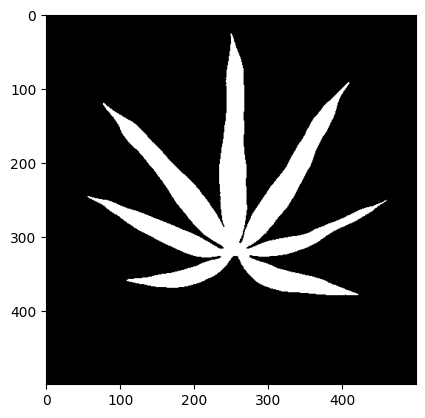

In [ ]:
import matplotlib.pyplot as plt
# Example usage
input_image = Image.open('/content/drive/My Drive/Dataset/Raw for Testing/20_1.JPG')
output_image = adaptive_threshold_test(input_image)
plt.imshow(output_image, cmap='gray')
plt.show()

In [ ]:
# Define the transformation for the test data
test_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])

In [ ]:
# Define the pixel accuracy function
def pixel_accuracy(output, target):
    output = output.sigmoid().data.cpu().numpy()
    output = (output > 0.5).astype(np.uint8)
    target = target.data.cpu().numpy()

    correct = (output == target).sum()
    total = np.product(target.shape)

    return correct / total

In [ ]:
from torchvision import transforms
# Modified adaptive_threshold_test function
def adaptive_threshold_test_1(input_image, ground_truth_mask):
    with torch.no_grad():
        input_tensor = test_transform(input_image).unsqueeze(0)
        target_tensor = test_transform(ground_truth_mask).unsqueeze(0)

        output = model(input_tensor)

        return output, target_tensor

In [ ]:
# Example usage
input_image = Image.open('/content/drive/My Drive/Dataset/Raw for Testing/20_1.JPG')
ground_truth_mask = Image.open('/content/drive/My Drive/Dataset/Raw for Testing/20_1.png')

output, target = adaptive_threshold_test_1(input_image, ground_truth_mask)
accuracy = pixel_accuracy(output, target)

print(f"Pixel Accuracy: {accuracy:.4f}")

Pixel Accuracy: 0.9995


<ipython-input-26-41cf13ad5c32>:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  accuracy = pixel_accuracy(output, target)
